<a href="https://colab.research.google.com/github/Ping-Jung/my-web/blob/main/lstm_b08502173_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multivariate Multistep Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Downloading the dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

--2022-05-20 08:45:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip’

household_power_con 100%[===================>]  19.68M  35.9MB/s    in 0.5s    

2022-05-20 08:45:40 (35.9 MB/s) - ‘household_power_consumption.zip’ saved [20640916/20640916]



In [ ]:
!unzip household_power_consumption.zip  

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  


**Text to CSV**

In [ ]:
df=pd.read_csv(r'household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


**Imputing Null values**

In [ ]:
# View the missing value
df = df.replace('?', np.nan)
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
def fill_missing(values):
    """
    values: the values from df
    """
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]

In [ ]:
df = df.astype('float32')
# TODO: 
# impute the null values using fill_missing function
# and then check the missing value again by df.isnull().sum()
fill_missing(df.values)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

**Downsampling of Data from minutes to Days**

In [ ]:
daily_df = df.resample('D').sum()

In [ ]:
daily_df.head(20)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0
2006-12-21,1723.287964,144.434006,347096.40625,7266.399902,1765.0,2692.0,10456.0
2006-12-22,2341.337891,186.906006,347305.75000,9897.000000,3151.0,350.0,11131.0
2006-12-23,4773.386230,221.470001,345795.93750,20200.400391,2669.0,425.0,14726.0
2006-12-24,2550.011963,149.899994,348029.90625,11002.200195,1703.0,5082.0,6891.0


In [ ]:
daily_df.shape, df.shape

((1442, 7), (2075259, 7))

**Train - Test Split**

In [ ]:
# TODO: split the data daily_df into train_df and test_df with the ratio of 75% and 25%, resptively.
# Notice the ignore the first row because of the header of the data.
train_df=daily_df.iloc[1:1081,]     # 75% and 25%
test_df=daily_df.iloc[1081:1441,]


In [ ]:
train_df.shape, test_df.shape

((1080, 7), (360, 7))

Scaling the values for faster training of the models.

In [ ]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_' + i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [ ]:
# verify the data range
print('min value:', np.min(train.values), 'max value:', np.max(train.values))

min value: -1.0 max value: 1.0000002


 For this case, let's assume that given past 10 days observations, forecast the next 5 days observations. 

In [ ]:
# For this case, let's assume that
# Given past 10 days observations, forecast the next 5 days observations. 
n_past = 10
n_future = 5 
n_features = 7
print(type(train))

<class 'pandas.core.frame.DataFrame'>


**Converting the series to samples for supervised learning**

In [ ]:
def split_series(series,n_past,n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
   
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past = series.iloc[window_start:past_end,:] 
    future= series.iloc[past_end:future_end,:]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
# TODO: split train and test into input and target samples
X_train, y_train = split_series(train,n_past,n_future)

X_test, y_test =split_series(test,n_past,n_future)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
X_test.shape

(346, 10, 7)

**Model Architecture**

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer. 

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
# 
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))    # define the input layer with shape: (n_past, n_features)
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)             # define the encoded LSTM layer with 100 LSTM units
encoder_outputs1 = encoder_l1(encoder_inputs)                         # get the output of LSTM layer, including (encoder output, the encoder states)
encoder_outputs_1 = encoder_outputs1[0]
encoder_states_1 = encoder_outputs1[1:]
#
# because we predict 5 future observation, so the input should have 5 input
# that why we use RepeatVector for repeating encoder output 5 times as the decoder inputs
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs_1)
#
# define the decoded LSTM layer, input the decoder inputs to get prediction
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states_1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
# define the e1d1 model by combine encoder and decoder together
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        43200       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm[0][0]']                   
                                                                                              

 **Training the model E1D1**


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25
34/34 [==============================] - 5s 45ms/step - loss: 0.0532 - val_loss: 0.0330 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - 1s 20ms/step - loss: 0.0358 - val_loss: 0.0314 - lr: 9.0000e-04
Epoch 3/25
34/34 [==============================] - 1s 22ms/step - loss: 0.0350 - val_loss: 0.0315 - lr: 8.1000e-04
Epoch 4/25
34/34 [==============================] - 1s 22ms/step - loss: 0.0345 - val_loss: 0.0306 - lr: 7.2900e-04
Epoch 5/25
34/34 [==============================] - 1s 18ms/step - loss: 0.0345 - val_loss: 0.0303 - lr: 6.5610e-04
Epoch 6/25
34/34 [==============================] - 1s 18ms/step - loss: 0.0342 - val_loss: 0.0304 - lr: 5.9049e-04
Epoch 7/25
34/34 [==============================] - 1s 17ms/step - loss: 0.0340 - val_loss: 0.0302 - lr: 5.3144e-04
Epoch 8/25
34/34 [==============================] - 1s 18ms/step - loss: 0.0337 - val_loss: 0.0304 - lr: 4.7830e-04
Epoch 9/25
34/34 [==============================] - 1s 18ms/step - loss: 0.0

Visualization

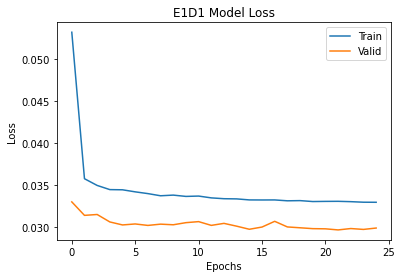

In [ ]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

Prediction on validation set

In [ ]:
# do prediction on X_test
pred_test_e1d1 =model_e1d1.predict(X_test)

# do prediction on X_train
pred_train_e1d1 =model_e1d1.predict(X_train)


Inverse Scaling of the predicted values

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_test_e1d1[:,:,index] = scaler.inverse_transform(pred_test_e1d1[:,:,index])
    pred_train_e1d1[:,:,index]=scaler.inverse_transform(pred_train_e1d1[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

**Checking Error** 

In [ ]:
from sklearn.metrics import mean_absolute_error
 
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day", j, ":", "MAE-E1D1 : ", mean_absolute_error(y_test[:,j-1,index],pred_test_e1d1[:,j-1,index]))
  print()
  print()
  

Global_active_power
Day 1 : MAE-E1D1 :  242.97029
Day 2 : MAE-E1D1 :  255.53401
Day 3 : MAE-E1D1 :  266.6925
Day 4 : MAE-E1D1 :  271.515
Day 5 : MAE-E1D1 :  278.2148


Global_reactive_power
Day 1 : MAE-E1D1 :  30.34012
Day 2 : MAE-E1D1 :  31.710209
Day 3 : MAE-E1D1 :  32.35749
Day 4 : MAE-E1D1 :  32.73835
Day 5 : MAE-E1D1 :  33.025024


Voltage
Day 1 : MAE-E1D1 :  1215.7314
Day 2 : MAE-E1D1 :  1335.1632
Day 3 : MAE-E1D1 :  1439.1141
Day 4 : MAE-E1D1 :  1528.4009
Day 5 : MAE-E1D1 :  1594.0426


Global_intensity
Day 1 : MAE-E1D1 :  1023.85443
Day 2 : MAE-E1D1 :  1070.0708
Day 3 : MAE-E1D1 :  1113.4523
Day 4 : MAE-E1D1 :  1135.1857
Day 5 : MAE-E1D1 :  1166.4244


Sub_metering_1
Day 1 : MAE-E1D1 :  989.42377
Day 2 : MAE-E1D1 :  993.8548
Day 3 : MAE-E1D1 :  1003.64777
Day 4 : MAE-E1D1 :  1007.9447
Day 5 : MAE-E1D1 :  1003.2231


Sub_metering_2
Day 1 : MAE-E1D1 :  1362.7279
Day 2 : MAE-E1D1 :  1349.2821
Day 3 : MAE-E1D1 :  1352.9741
Day 4 : MAE-E1D1 :  1356.3392
Day 5 : MAE-E1D1 :  1352.4393

**Practice**

Try to implement an Encoder-Decoder LSTM model with follow desscription

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers. 

In [30]:
# TODO: Define the E2D2 model with two encoder layers and two decoder layers. 
# n_features ==> no of features at each timestep in the data.
#E2D2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))    # define the input layer with shape: (n_past, n_features)
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)             # define the encoded LSTM layer with 100 LSTM units
encoder_outputs1 = encoder_l1(encoder_inputs)                         # get the output of LSTM layer, including (encoder output, the encoder states)
encoder_outputs_1 = encoder_outputs1[0]
encoder_states_1 = encoder_outputs1[1:]
#
# because we predict 5 future observation, so the input should have 5 input
# that why we use RepeatVector for repeating encoder output 5 times as the decoder inputs
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs_1)
# define the decoded LSTM layer, input the decoder inputs to get prediction
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states_1)
decoder_output1=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

encoder_l2=tf.keras.layers.LSTM(100,return_state=True)
encoder_outputs2=encoder_l2(decoder_output1)
encoder_outputs_2=encoder_outputs2[0]
encoder_states_2=encoder_outputs2[1:]

decoder_inputs2 = tf.keras.layers.RepeatVector(n_future)(encoder_outputs_2)
decoder_l2=tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs2, initial_state = encoder_states_2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

# define the e1d1 model by combine encoder and decoder together
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lstm_17 (LSTM)                 [(None, 100),        43200       ['input_6[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_8 (RepeatVector)  (None, 5, 100)      0           ['lstm_17[0][0]']                
                                                                                            

Train E2D2 model

In [31]:
# TODO: Compile the Adam optimizer and Huber loss then train E2D2 model
X_train, y_train = split_series(train,n_past,n_future)
X_test, y_test =split_series(test,n_past,n_future)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25
34/34 [==============================] - 16s 90ms/step - loss: 0.0661 - val_loss: 0.0397 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - 1s 30ms/step - loss: 0.0396 - val_loss: 0.0341 - lr: 9.0000e-04
Epoch 3/25
34/34 [==============================] - 1s 32ms/step - loss: 0.0367 - val_loss: 0.0321 - lr: 8.1000e-04
Epoch 4/25
34/34 [==============================] - 1s 32ms/step - loss: 0.0353 - val_loss: 0.0318 - lr: 7.2900e-04
Epoch 5/25
34/34 [==============================] - 1s 32ms/step - loss: 0.0350 - val_loss: 0.0314 - lr: 6.5610e-04
Epoch 6/25
34/34 [==============================] - 1s 30ms/step - loss: 0.0346 - val_loss: 0.0304 - lr: 5.9049e-04
Epoch 7/25
34/34 [==============================] - 1s 29ms/step - loss: 0.0342 - val_loss: 0.0312 - lr: 5.3144e-04
Epoch 8/25
34/34 [==============================] - 1s 30ms/step - loss: 0.0341 - val_loss: 0.0310 - lr: 4.7830e-04
Epoch 9/25
34/34 [==============================] - 1s 30ms/step - loss: 0.

Show the training loss

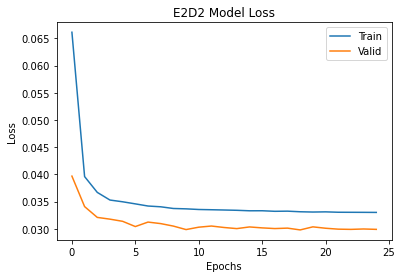

In [32]:
# TODO: Show the training and validation loss of E2D2

plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

Make prediction, make reverse scaling the predicted values and compute MSE

In [33]:
# Make prediction, make reverse scaling the predicted values and compute MSE
# do prediction on X_test
pred_test_e2d2 =model_e2d2.predict(X_test)

# do prediction on X_train
pred_train_e2d2 =model_e2d2.predict(X_train)

for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_test_e2d2[:,:,index] = scaler.inverse_transform(pred_test_e2d2[:,:,index])
    pred_train_e2d2[:,:,index]=scaler.inverse_transform(pred_train_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

 
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day", j, ":", "MAE-E2D2 : ", mean_absolute_error(y_test[:,j-1,index],pred_test_e2d2[:,j-1,index]))
  print()
  print()
  

print("Conclusion: the E1D1 is better since the E2D2 is likely to overfit")  

Global_active_power
Day 1 : MAE-E2D2 :  245.82086
Day 2 : MAE-E2D2 :  258.1721
Day 3 : MAE-E2D2 :  272.66803
Day 4 : MAE-E2D2 :  275.51883
Day 5 : MAE-E2D2 :  277.67392


Global_reactive_power
Day 1 : MAE-E2D2 :  29.222746
Day 2 : MAE-E2D2 :  30.677977
Day 3 : MAE-E2D2 :  31.164429
Day 4 : MAE-E2D2 :  31.629414
Day 5 : MAE-E2D2 :  32.05416


Voltage
Day 1 : MAE-E2D2 :  1182.7478
Day 2 : MAE-E2D2 :  1326.1155
Day 3 : MAE-E2D2 :  1434.7096
Day 4 : MAE-E2D2 :  1519.8562
Day 5 : MAE-E2D2 :  1587.6573


Global_intensity
Day 1 : MAE-E2D2 :  1033.3301
Day 2 : MAE-E2D2 :  1080.549
Day 3 : MAE-E2D2 :  1143.4153
Day 4 : MAE-E2D2 :  1157.6522
Day 5 : MAE-E2D2 :  1169.7854


Sub_metering_1
Day 1 : MAE-E2D2 :  1026.6704
Day 2 : MAE-E2D2 :  1027.4221
Day 3 : MAE-E2D2 :  1024.1833
Day 4 : MAE-E2D2 :  1022.01245
Day 5 : MAE-E2D2 :  1024.0342


Sub_metering_2
Day 1 : MAE-E2D2 :  1366.38
Day 2 : MAE-E2D2 :  1348.9003
Day 3 : MAE-E2D2 :  1351.4617
Day 4 : MAE-E2D2 :  1366.0651
Day 5 : MAE-E2D2 :  1376.86